In [14]:
import pandas as pd
import numpy as np
import mne
import pickle 
from pickle import dump
from mne.io import  read_raw_edf
import matplotlib.pyplot as plt
import seaborn as sns
from source import data_import
from filter_eeg_channels_web import filter_eeg_channels
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import joblib
import tempfile
import os
from source.constants import CHANNELS, FREQUENCY_RANGES
from extract_features import extract_features
import scipy
from scipy.signal import butter, lfilter

In [2]:
temp_filepath ='data/chb05/chb05_06.edf'

In [3]:
edf_df_classifier = data_import.load_segmented_unlabeled_data(temp_filepath, channels=CHANNELS)

KeyError: Timedelta('0 days 01:00:00')

In [57]:
edf_df_classifier= edf_df_classifier.reset_index(drop=True)

In [58]:
exclude_ranges=[[58, 62], [118, 122]]
filtered = filter_eeg_channels(edf_df_classifier, CHANNELS, fs=256, exclude_ranges=exclude_ranges, Q=30)

In [59]:
 # Extract features from the preprocessed data
extracted_features = extract_features(filtered)

In [61]:
extracted_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 70 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   F4-C4_std          720 non-null    float64
 1   F4-C4_var          720 non-null    float64
 2   F4-C4_mean         720 non-null    float64
 3   F4-C4_abs_mean     720 non-null    float64
 4   F4-C4_delta        720 non-null    float64
 5   F4-C4_theta        720 non-null    float64
 6   F4-C4_gamma        720 non-null    float64
 7   F3-C3_std          720 non-null    float64
 8   F3-C3_var          720 non-null    float64
 9   F3-C3_mean         720 non-null    float64
 10  F3-C3_abs_mean     720 non-null    float64
 11  F3-C3_delta        720 non-null    float64
 12  F3-C3_theta        720 non-null    float64
 13  F3-C3_gamma        720 non-null    float64
 14  FT9-FT10_std       720 non-null    float64
 15  FT9-FT10_var       720 non-null    float64
 16  FT9-FT10_mean      720 non

In [3]:
df = data_import.load_pyarrow(file_name="feature_extracted")

/Users/anabroggini/Documents/bootcamp/ai2/source/../data/feature_extracted.arrow was loaded.


In [22]:
df.head()

,epoch,segment_id,F4-C4_std,F4-C4_var,F4-C4_mean,F4-C4_abs_mean,F4-C4_delta,F4-C4_theta,F4-C4_gamma,F3-C3_std,...,FP1-F3_theta,FP1-F3_gamma,CZ-PZ_std,CZ-PZ_var,CZ-PZ_mean,CZ-PZ_abs_mean,CZ-PZ_delta,CZ-PZ_theta,CZ-PZ_gamma,target
0,0,0,19.215291,369.227396,1.677760,14.539727,39.509423,15.649456,1.143016,21.315638,...,92.822474,22.441816,16.368013,267.911860,0.692305,13.053429,33.181709,18.606278,0.272641,False
1,0,1,19.292719,372.208995,-0.391839,15.081409,57.166882,13.481116,1.218430,25.477037,...,76.808250,33.427544,18.012047,324.433840,-0.487618,14.154003,40.078259,21.722061,0.268936,False
2,0,2,26.026211,677.363658,1.356797,18.727514,112.603482,22.111449,0.943441,27.729263,...,176.024973,8.914849,22.813508,520.456131,1.294472,18.522101,78.066994,19.695134,0.256728,False
3,0,3,26.999490,728.972443,-1.657887,18.877600,148.551723,15.161321,1.178056,29.614908,...,75.730101,21.215121,19.942794,397.715029,-0.476040,15.324033,60.340596,18.821070,0.258679,False
4,0,4,23.273241,541.643731,0.776272,17.412866,77.372989,25.561364,1.423834,23.413506,...,284.475569,16.303152,18.725786,350.655046,1.382429,15.186356,46.083693,24.182717,0.271254,False


In [5]:
y = df["target"]
X = df.drop(columns=["epoch", "target","segment_id" ])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [16]:
model_path = "best_xgboost_model.pkl"  
loaded_model=joblib.load(model_path)


In [17]:
loaded_model=joblib.load('best_xgboost_model.pkl')

In [18]:

# Perform classification using the loaded model
predictions = loaded_model.predict(X_test) 


In [20]:
confusion = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(confusion)

Confusion Matrix:
[[427  13]
 [ 19   3]]


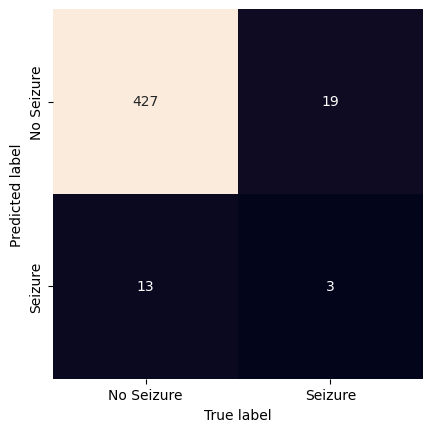

In [21]:
labels = ['No Seizure', 'Seizure']
mat = confusion.T  # Transpose to match your reference code
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, xticklabels=labels, yticklabels=labels)
plt.xlabel('True label')
plt.ylabel('Predicted label')
#plt.title(f'Confusion Matrix for {XG boost}')
plt.show()
print()

In [4]:
channels=CHANNELS
file_path ='data/chb05/chb05_06.edf'


In [5]:
from pathlib import Path

In [6]:
segment_duration = 5
    # load edf into pandas df
if channels is None:
    ch = None
else:
    ch = channels.copy()
    if 'T8-P8-1' in ch:
        ch.remove('T8-P8-1')
        ch.append('T8-P8')
    if 'T8-P8-0' in ch:
        ch.remove('T8-P8-0')
        ch.append('T8-P8')

file_path = Path(file_path)
raw = mne.io.read_raw_edf(file_path, preload=False, include=ch, verbose='ERROR')
sample_freq = str(1/raw.info['sfreq'] * 1E9) + 'N' # in Nanoseconds
df = raw.to_data_frame(index='time')
time_index = pd.timedelta_range(start=0, periods=df.shape[0], freq=sample_freq)
df = df.set_index(time_index)

# do segmentation of whole file
nr_segments = int(len(df.index) // (segment_duration * raw.info['sfreq']))
crop_at = pd.Timedelta(seconds=nr_segments * segment_duration)
if crop_at > df.index[-1]:
    iloc_idx = None # exclusive slicing index exceeds data length by one timestep -> use whole data
else:
    iloc_idx = df.index.get_loc(crop_at)
segments = df.iloc[:iloc_idx, :].copy()
# add segment numbers and epoch id
# segments['epoch'] = 0
segments['segment_id'] = [i for i in range(nr_segments) for _ in range(int(len(segments)/nr_segments))]

In [7]:
segments

channel,F7-T7,FP1-F3,F3-C3,FP2-F4,F4-C4,T8-P8-0,FZ-CZ,CZ-PZ,FT9-FT10,T8-P8-1,segment_id
0 days 00:00:00,50.207570,-112.722833,5.665446,18.949939,13.870574,-55.286935,-2.148962,69.743590,185.006105,-55.286935,0
0 days 00:00:00.003906250,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0
0 days 00:00:00.007812500,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0
0 days 00:00:00.011718750,0.195360,0.195360,0.195360,0.195360,0.195360,0.976801,0.195360,0.195360,-0.976801,0.976801,0
0 days 00:00:00.015625,1.367521,0.586081,-0.195360,0.195360,0.195360,-0.195360,0.195360,0.586081,1.367521,-0.195360,0
...,...,...,...,...,...,...,...,...,...,...,...
0 days 00:59:59.980468750,124.053724,40.439560,4.102564,-38.095238,-37.704518,-33.797314,-34.969475,-56.068376,-136.166056,-33.797314,719
0 days 00:59:59.984375,106.862027,40.439560,-1.758242,-44.346764,-36.532357,-29.890110,-38.485958,-60.757021,-129.523810,-29.890110,719
0 days 00:59:59.988281250,92.796093,40.830281,-7.619048,-38.485958,-33.406593,-27.155067,-40.830281,-70.525031,-123.272283,-27.155067,719
0 days 00:59:59.992187500,75.213675,40.048840,-16.214896,-33.015873,-33.406593,-22.075702,-39.267399,-79.902320,-116.630037,-22.075702,719


In [94]:
iloc_idx

920319

In [92]:
crop_at

Timedelta('0 days 00:59:54.996093750')

In [81]:
print(crop_at)

0 days 01:00:00


In [74]:
pd.Timedelta(seconds=nr_segments * segment_duration)

Timedelta('0 days 01:00:00')